<a href="https://colab.research.google.com/github/Alf-caput/NonVerbalAudioClassifier/blob/main/src/tensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
import os

zip_filename = 'vs_release_16k.zip'

if not os.path.exists(zip_filename):
    os.system("wget https://www.dropbox.com/s/fuld3z222j9t1oy/vs_release_16k.zip")

Dentro de vs_release_16k.zip descomprimimos:  
- audio_16k  

Nos servimos del módulo zipfile para descomprimir.  

In [146]:
import os
from zipfile import ZipFile
from concurrent.futures import ThreadPoolExecutor

audio_dir = 'audio_16k/'

if not os.path.exists(audio_dir):
    with ZipFile(zip_filename, 'r') as zf:
        with ThreadPoolExecutor() as exe:
            for file in zf.namelist():
                if file.startswith(audio_dir):
                    exe.submit(zf.extract, file)

In [159]:
import tensorflow as tf

audio_dir = 'audio_16k/'
seed = 42

tf.random.set_seed(seed)

filenames = tf.io.gfile.glob(audio_dir + '*')
filenames = tf.random.shuffle(filenames, seed)

print('Total audios:', len(filenames))
print('Example:', filenames)

Total audios: 20982
Example: tf.Tensor(
[b'audio_16k/m1499_0_throatclearing.wav' b'audio_16k/m0639_0_sneeze.wav'
 b'audio_16k/f1646_0_sigh.wav' ... b'audio_16k/f2073_0_sniff.wav'
 b'audio_16k/m2223_0_cough.wav' b'audio_16k/m0225_0_throatclearing.wav'], shape=(20982,), dtype=string)


In [148]:
test_file = filenames[0]

def get_label(file_path):
  label = tf.strings.split(
    input=file_path,
    sep='_')[-1]

  label = tf.strings.split(
    input=label,
    sep='.')[0]

  label

  return label
get_label(test_file), test_file

(<tf.Tensor: shape=(), dtype=string, numpy=b'throatclearing'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m1499_0_throatclearing.wav'>)

In [149]:
def get_signal(file_path):
  audio_binary = tf.io.read_file(file_path)
  signal = tf.audio.decode_wav(audio_binary)[0]
  return tf.squeeze(signal, axis=-1)

get_signal(test_file), test_file

(<tf.Tensor: shape=(43691,), dtype=float32, numpy=
 array([-9.1552734e-05, -1.5258789e-04, -2.7465820e-04, ...,
         1.8310547e-04,  2.4414062e-04,  2.1362305e-04], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'audio_16k/m1499_0_throatclearing.wav'>)

In [150]:
AUTOTUNE = tf.data.AUTOTUNE
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

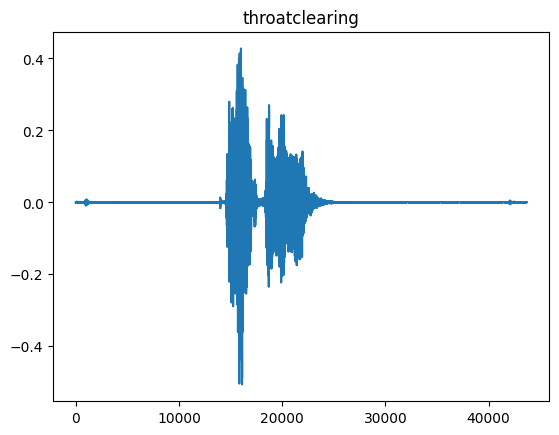

In [151]:
import matplotlib.pyplot as plt
for elem in ds_signals.take(1):
  signal, label = elem
  plt.plot(signal)
  plt.title(label.numpy().decode('utf-8'))

In [152]:
def remove_shortaudio(filename):
  if get_signal(filename).shape[0] < min_len:
    tf.io.gfile.remove(filename)

initial_file_count = 21024

if len(filenames) >= initial_file_count:
  # Remove less than 0.1s audios (16kHz then 1600 frames)
  min_len = 1600
  with ThreadPoolExecutor() as exe:
    for file in filenames:
      exe.submit(remove_shortaudio, file)

  filenames = tf.io.gfile.glob(audio_dir + '*')

print('Total audios:', len(filenames))


Total audios: 20982


In [153]:
ds_files = tf.data.Dataset.from_tensor_slices(filenames)
ds_signals = ds_files.map(lambda x: (get_signal(x), get_label(x)), num_parallel_calls=AUTOTUNE)

In [154]:
for elem in ds_signals.take(1):
  print(elem)

(<tf.Tensor: shape=(43691,), dtype=float32, numpy=
array([-9.1552734e-05, -1.5258789e-04, -2.7465820e-04, ...,
        1.8310547e-04,  2.4414062e-04,  2.1362305e-04], dtype=float32)>, <tf.Tensor: shape=(), dtype=string, numpy=b'throatclearing'>)


In [155]:
vocal_sounds = ['cough', 'laughter', 'sigh', 'sneeze', 'sniff', 'throatclearing']
num_sounds = len(vocal_sounds)

def normalize(audio, label):
  label = tf.one_hot(label, num_sounds)
  return audio, label

In [156]:
for elem in ds_signals.map(normalize).take(1):
  my_label = elem[1]
my_label.numpy()

TypeError: in user code:

    File "<ipython-input-106-e12ce616593a>", line 6, in normalize  *
        label = tf.one_hot(label, num_sounds)

    TypeError: Value passed to parameter 'indices' has DataType string not in list of allowed values: uint8, int8, int32, int64


In [ ]:
import tensorflow as tf

# Función para ajustar la longitud del ragged tensor
def ajustar_longitud(ragged_tensor, longitud_deseada):
    # Convierte el ragged tensor a un tensor denso rellenando los valores faltantes con ceros
    tensor_denso = ragged_tensor.to_tensor(default_value=0)

    # Recorta o rellena con ceros para ajustar la longitud deseada
    if tensor_denso.shape[1] > longitud_deseada:
        # Si es más largo, recorta el final
        tensor_denso = tensor_denso[:, :longitud_deseada]
    elif tensor_denso.shape[1] < longitud_deseada:
        # Si es más corto, rellena con ceros al final
        ceros_restantes = longitud_deseada - tensor_denso.shape[1]
        padding = tf.zeros((tensor_denso.shape[0], ceros_restantes), dtype=tensor_denso.dtype)
        tensor_denso = tf.concat([tensor_denso, padding], axis=1)

    return tensor_denso

# Ejemplo de un ragged tensor
ragged_tensor = tf.ragged.constant([[1, 2, 3], [4, 5], [6, 7, 8, 9]])

# Longitud deseada del tensor resultante
longitud_deseada = 3

# Ajustar la longitud del ragged tensor
tensor_ajustado = ajustar_longitud(ragged_tensor, longitud_deseada)

print("Ragged tensor original:")
print(ragged_tensor)

print("\nTensor ajustado:")
print(tensor_ajustado)


In [ ]:
def normalize(audio, label):
  audio = tf.cast(image, tf.float32) / 255.0
  label = tf.one_hot(label, depth=num_classes)
  return audio, label


In [ ]:

ds_signals.take(1).map(lambda tensor, label: tensor, tf.onehot)
for elem in ds_signals.take(1):
  print(elem)

In [ ]:
num_train = len(ds_signals)

RATIO = 0.2
test_size = int(RATIO * num_train)

ds_train = ds_signals.skip(test_size)
ds_test = ds_signals.take(test_size)

In [ ]:
num_train = len(ds_train)

RATIO = 0.2
validation_size = int(RATIO * num_train)

ds_fit = ds_signals.skip(validation_size)
ds_val = ds_signals.take(validation_size)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 1024
ds_fit = (
    ds_fit
    .cache()
    .shuffle(len(ds_fit))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

ds_val = (
    ds_val
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr=0.0001)

epoch_wait = 5
# Crear el EarlyStopping callback con la función on_train_end
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=epoch_wait)

# Definimos los callbacks
callbacks = [early_stopping, reduce_lr]

In [ ]:
# Establecer la semilla global
seed_value = 42
tf.random.set_seed(seed_value)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(64, activation='relu', input_shape=(64000,)),  # Capa de entrada con 64 neuronas
    Dense(32, activation='relu'),  # Capa oculta con 32 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

In [ ]:
history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Arquitectura de la red convolucional
model = Sequential([
    Dense(1024, activation='relu', input_shape=(64000,)),  # Capa de entrada con 1024 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(512, activation='relu'),  # Capa oculta con 512 neuronas
    Dense(6, activation='sigmoid')  # Capa de salida con una neurona para clasificación binaria
])

# Compila el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Resumen de la arquitectura del modelo
model.summary()

history = model.fit(ds_fit, epochs=100, validation_data=ds_val, callbacks=callbacks)

In [ ]:
BATCH_SIZE = 128
ds_eval = (
    ds_test.cache()
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)
test_loss, test_acc = model.evaluate(ds_eval)

print('Test accuracy:', test_acc)